/tmp/ipykernel_1010120/378746353.py:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Temperature')


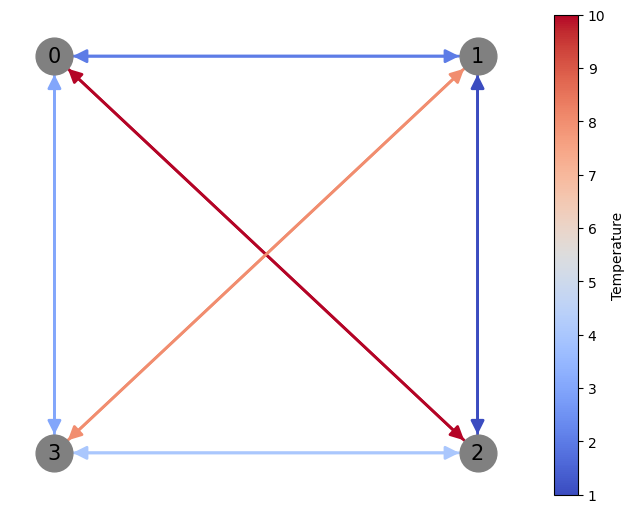

In [205]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Create a new graph
G = nx.Graph()

# Add nodes
G.add_node(0, pos=(0, 1))
G.add_node(1, pos=(1, 1))
G.add_node(2, pos=(1, 0))
G.add_node(3, pos=(0, 0))

# Add edges with weights and temperatures
G.add_edge(0, 1, weight=2, temp=2)
G.add_edge(0, 2, weight=3, temp=10)
G.add_edge(0, 3, weight=2, temp=3)
G.add_edge(1, 2, weight=2, temp=1)
G.add_edge(2, 3, weight=2, temp=4)
G.add_edge(1, 3, weight=3, temp=8)

#set weights to be product of weight and temp
for u, v, w in G.edges(data=True):
    G[u][v]['weight'] *= G[u][v]['temp']

# Convert graph to a directed graph
G = nx.DiGraph(G)

# Get the positions
pos = nx.get_node_attributes(G, 'pos')

# Specify the weights as labels
edge_labels = {(i, j): w['weight'] for i, j, w in G.edges(data=True)}

# Prepare edge colors based on temperature
temps = [G[u][v]['temp'] for u, v in G.edges()]
norm = mcolors.Normalize(vmin=min(temps), vmax=max(temps))
cmap = cm.coolwarm
edge_colors = [cmap(norm(temp)) for temp in temps]

# Draw the graph with black nodes and white node labels
nx.draw(G, pos, with_labels=True, node_size=700, node_color='gray', edge_color=edge_colors, width=2, font_size=15, arrowsize=20)


# nx.draw_networkx_labels(G, pos, font_color='white', font_size=15)

# Color bar setup
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Temperature')

# Show plot
plt.show()


In [206]:
from dimod import BQM
def sp_objective(bqm: BQM, G: nx.DiGraph):
    # c_0 * x_0 + c_1 * x_1 + ... + c_n * x_n
    for u, v in G.edges():
        bqm.add_linear(f"x_{u}_{v}", G[u][v]['weight']) # 2*x_0_1 + ...
    return bqm

def sp_constraint(bqm: BQM, G: nx.DiGraph, s: int, e: int):
    
    c = []
    for u, v in G.out_edges(s):
        c.append((f"x_{u}_{v}", 1))
    # print(c)
    bqm.add_linear_equality_constraint(c, constant=-1, lagrange_multiplier=50)
    
    c = []
    for u, v in G.in_edges(s):
        c.append((f"x_{u}_{v}", 1))
    # print(c)
    bqm.add_linear_equality_constraint(c, constant=0, lagrange_multiplier=50)
    
    c = []
    for u, v in G.in_edges(e):
        c.append((f"x_{u}_{v}", 1))
    bqm.add_linear_equality_constraint(c, constant=-1, lagrange_multiplier=50)
    
    c = []
    for u, v in G.out_edges(e):
        c.append((f"x_{u}_{v}", 1))
    
    bqm.add_linear_equality_constraint(c, constant=0, lagrange_multiplier=50)
    for node in G.nodes():
        c = []
        if node == s or node == e:
            continue

        for u, v in G.out_edges(node):
            c.append((f"x_{u}_{v}", 1))
        for u, v in G.in_edges(node):
            c.append((f"x_{u}_{v}", -1))
        
        L = sum([G[u][v]['weight'] for u, v in G.edges()])
        bqm.add_linear_equality_constraint(c, constant=0, lagrange_multiplier=50)
        
    return bqm

In [207]:
from neal import SimulatedAnnealingSampler

def anneal(bqm, num_reads):
    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=num_reads)
    return sampleset

In [208]:
def sp_solution(num_reads, G: nx.DiGraph, start: int, end: int):
    
    bqm = BQM("BINARY")
    bqm = sp_objective(bqm, G)
    bqm = sp_constraint(bqm, G, start, end)

    sampleset = anneal(bqm, num_reads)

    # Do not modify anything below this line
    return sampleset, bqm

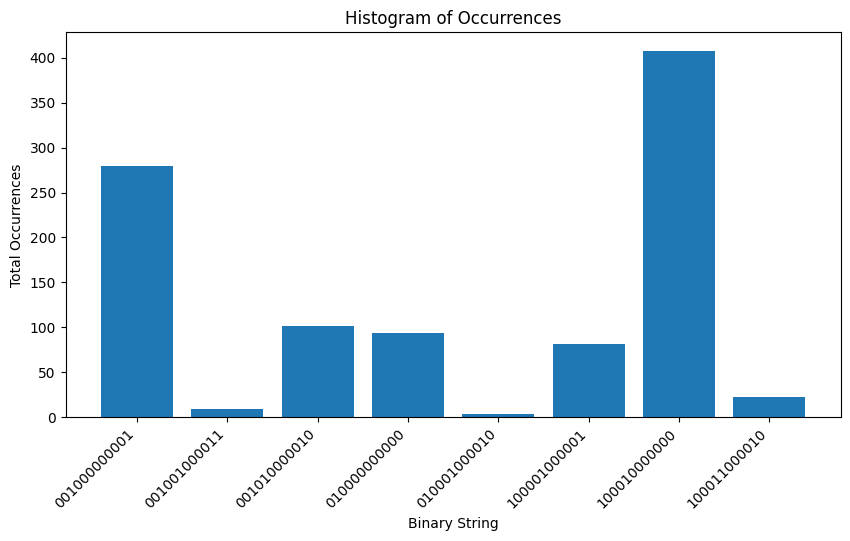

In [209]:
sampleset, bqm = sp_solution(1000, G, 0, 2)
ans = None

data = {}

sampleset = sampleset.aggregate()
for datum in sampleset.data(['sample', 'energy', 'num_occurrences']):
    binary_string = ''.join(str(datum.sample[key]) for key in datum.sample.keys())
    energy = datum.energy
    occurrences = datum.num_occurrences
    data[binary_string] = occurrences

ans = list(data.keys())[0]

sorted_data = dict(sorted(data.items(), key=lambda item: item[0]))
data = sorted_data

plt.figure(figsize=(10, 5))
plt.bar(list(data.keys()), list(data.values()))
plt.xlabel('Binary String')
plt.ylabel('Total Occurrences')
plt.title('Histogram of Occurrences')
plt.xticks(list(data.keys()), rotation=45, ha='right')
plt.show()


100010000000


/tmp/ipykernel_1010120/511472992.py:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Temperature')


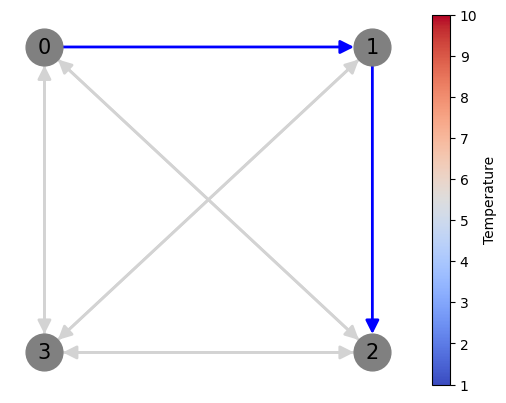

In [212]:
print(ans)

# Convert graph to a directed graph
display_G = nx.DiGraph(G)

# Get the positions
pos = nx.get_node_attributes(display_G, 'pos')

to_remove = [] 

for i, bit in enumerate(ans):
    if bit == '1':
        
        u,v = list(display_G.edges())[i]
        # set color of an edge to be green
        display_G[u][v]['color'] = 'blue'
        to_remove.append((v, u))
    else:
        u,v = list(display_G.edges())[i]
        # set color of an edge to be lavender
        display_G[u][v]['color'] = 'lightgrey'

        

display_G.remove_edges_from(to_remove)
edge_colors = list(nx.get_edge_attributes(display_G, 'color').values())
# Specify the weights as labels
edge_labels = {(i, j): w['weight'] for i, j, w in display_G.edges(data=True)}

# Prepare edge colors based on temperature
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Temperature')


# Draw the graph with black nodes and white node labels
nx.draw(display_G, pos, with_labels=True, node_size=700, node_color='gray', edge_color=edge_colors, width=2, font_size=15, arrowsize=20)

# Show plot
plt.show()